# INF442 Project: Power Consumption Weather
<span style="color:green">Students: </span> *Huu Nguyen Hoang, Gabriel Pereira de Carvalho*

### <font color='289C4E'>Table of contents<font><a class='anchor' id='top'></a>
    - [Python setup](#setup)
    - [Task 1: Data preprocessing](#1)

<h2 align=\"center\"> <font color='gray'>Python setup</font></h2> <a class=\"anchor\" id=\"setup\"></a>

In [6]:
!pip install -q numpy pandas missingno datetime seaborn matplotlib

import numpy as np
import pandas as pd
import missingno as msno
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

<h2 align=\"center\"> <font color='gray'>Task 1: Data preprocessing</font></h2> <a class=\"anchor\" id=\"1\"></a>

Our data folder has four *csv* files with data relative to the household. To facilitate our analysis, we will convert the *csv* files containing data from the household into a single dataframe.

In [7]:
df_2007 = pd.read_csv('p1-power-weather/household_power_consumption/household_power_consumption_2007.csv',  sep=';')
df_2007.columns =['Date', 'Time', 'global_active_power', 'global_reactive_power','voltage','global_intensity','sub_metering_1','sub_metering_2','sub_metering_3']

df_2008 = pd.read_csv('p1-power-weather/household_power_consumption/household_power_consumption_2008.csv',  sep=';')
df_2008.columns =['Date', 'Time', 'global_active_power', 'global_reactive_power','voltage','global_intensity','sub_metering_1','sub_metering_2','sub_metering_3']

df_2009 = pd.read_csv('p1-power-weather/household_power_consumption/household_power_consumption_2009.csv',  sep=';')
df_2009.columns =['Date', 'Time', 'global_active_power', 'global_reactive_power','voltage','global_intensity','sub_metering_1','sub_metering_2','sub_metering_3']

df_2010 = pd.read_csv('p1-power-weather/household_power_consumption/household_power_consumption_2010.csv',  sep=';')
df_2010.columns =['Date', 'Time', 'global_active_power', 'global_reactive_power','voltage','global_intensity','sub_metering_1','sub_metering_2','sub_metering_3']

#to facilitate preprocessing, we will concatenate the dataframes
df_list = [df_2007, df_2008, df_2009, df_2010]
df_household = pd.concat(df_list)

C:\Users\nguye\AppData\Local\Temp\ipykernel_25092\3375055808.py:1: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2007 = pd.read_csv('p1-power-weather/household_power_consumption/household_power_consumption_2007.csv',  sep=';')
C:\Users\nguye\AppData\Local\Temp\ipykernel_25092\3375055808.py:4: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2008 = pd.read_csv('p1-power-weather/household_power_consumption/household_power_consumption_2008.csv',  sep=';')
C:\Users\nguye\AppData\Local\Temp\ipykernel_25092\3375055808.py:7: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2009 = pd.read_csv('p1-power-weather/household_power_consumption/household_power_consumption_2009.csv',  sep=';')
C:\Users\nguye\AppData\Local\Temp\ipykernel_25092\3375055808.py:10: DtypeWarning: Columns (2,3,4,5,6,7) have mix

We have a dataframe with all data collected relative to the household. First, let's convert all dates to **DateTime** and all the numeric data from object data-type to float/int data-type:

In [8]:
df_household['date'] = pd.to_datetime(df_household['Date'] + ' ' + df_household['Time'], format='%d/%m/%Y %H:%M:%S')
df_household.drop(['Date', 'Time'], axis=1, inplace=True)

In [ ]:
df_household.replace('?', np.nan, inplace=True)

df_household['global_active_power'] = df_household['global_active_power'].astype('float')
df_household['global_reactive_power'] = df_household['global_reactive_power'].astype('float')
df_household['voltage'] = df_household['voltage'].astype('float')
df_household['global_intensity'] = df_household['global_intensity'].astype('float')
df_household['sub_metering_1'] = df_household['sub_metering_1'].astype('float')
df_household['sub_metering_2'] = df_household['sub_metering_2'].astype('float')
df_household['sub_metering_3'] = df_household['sub_metering_3'].astype('float')

df_household.describe(include='all')

,global_active_power,global_reactive_power,voltage,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3,date
count,2.027284e+06,2.027284e+06,2.027284e+06,2.027284e+06,2.027284e+06,2.027284e+06,2.027284e+06,2053259
mean,1.082831e+00,1.236313e-01,2.408333e+02,4.590848e+00,1.120551e+00,1.288581e+00,6.448125e+00,2008-12-13 22:31:27.762031104
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,2007-01-01 00:01:00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2007-12-23 11:15:30
50%,5.940000e-01,1.000000e-01,2.410000e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2008-12-13 22:31:00
75%,1.520000e+00,1.940000e-01,2.428700e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01,2009-12-05 09:46:30
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01,2010-11-26 21:02:00
std,1.049284e+00,1.126387e-01,3.231264e+00,4.410805e+00,6.147376e+00,5.786211e+00,8.434116e+00,NaN


Now we must repeat this procedure for the data relative to the weather stations. In fact, we will need an additional step because we must filter only the data relative to the *Orly* station which is pertinent to the household.

In [ ]:
csv_file_names = [
    'synop.200701.csv', 'synop.200702.csv', 'synop.200703.csv', 'synop.200704.csv', 'synop.200705.csv', 'synop.200706.csv',
    'synop.200707.csv', 'synop.200708.csv', 'synop.200709.csv', 'synop.200710.csv', 'synop.200711.csv', 'synop.200712.csv',
    'synop.200801.csv', 'synop.200802.csv', 'synop.200803.csv', 'synop.200804.csv', 'synop.200805.csv', 'synop.200806.csv',
    'synop.200807.csv', 'synop.200808.csv', 'synop.200809.csv', 'synop.200810.csv', 'synop.200811.csv', 'synop.200812.csv',
    'synop.200901.csv', 'synop.200902.csv', 'synop.200903.csv', 'synop.200904.csv', 'synop.200905.csv', 'synop.200906.csv',
    'synop.200907.csv', 'synop.200908.csv', 'synop.200909.csv', 'synop.200910.csv', 'synop.200911.csv', 'synop.200912.csv',
    'synop.201001.csv', 'synop.201002.csv', 'synop.201003.csv', 'synop.201004.csv', 'synop.201005.csv', 'synop.201006.csv',
    'synop.201007.csv', 'synop.201008.csv', 'synop.201009.csv', 'synop.201010.csv', 'synop.201011.csv', 'synop.201012.csv']

df_list = []
for csv_file_name in csv_file_names:
    dataframe_i = pd.read_csv('p1-power-weather/weather/' + csv_file_name,  sep=';')
    df_list.append(dataframe_i)

df_station = pd.concat(df_list)

KeyboardInterrupt: 

In [ ]:
#We keep only data relative to Orly station
df_station = df_station[df_station.numer_sta == 7149]
#we can now delete the numer_sta column
df_station.drop(['numer_sta'], axis=1, inplace=True)

In [ ]:
df_station.columns

Index(['date', 'pmer', 'tend', 'cod_tend', 'dd', 'ff', 't', 'td', 'u', 'vv',
       'ww', 'w1', 'w2', 'n', 'nbas', 'hbas', 'cl', 'cm', 'ch', 'pres',
       'niv_bar', 'geop', 'tend24', 'tn12', 'tn24', 'tx12', 'tx24', 'tminsol',
       'sw', 'tw', 'raf10', 'rafper', 'per', 'etat_sol', 'ht_neige', 'ssfrai',
       'perssfrai', 'rr1', 'rr3', 'rr6', 'rr12', 'rr24', 'phenspe1',
       'phenspe2', 'phenspe3', 'phenspe4', 'nnuage1', 'ctype1', 'hnuage1',
       'nnuage2', 'ctype2', 'hnuage2', 'nnuage3', 'ctype3', 'hnuage3',
       'nnuage4', 'ctype4', 'hnuage4', 'Unnamed: 59'],
      dtype='object')

In [ ]:
df_station['date'] = pd.to_datetime(df_station['date'], format='%Y%m%d%H%M%S')

df_station.replace('?', np.nan, inplace=True)
df_station.replace('mq', np.nan, inplace=True)

#pmer;tend;cod_tend;dd;ff;t;td;u;vv;ww;w1;w2;n;nbas;hbas;cl;cm;ch;pres;niv_bar;geop;tend24;tn12;tn24;tx12;tx24;tminsol;sw;tw;raf10;
#rafper;per;etat_sol;ht_neige;ssfrai;perssfrai;
#rr1;rr3;rr6;rr12;rr24;phenspe1;phenspe2;phenspe3;phenspe4;nnuage1;ctype1;hnuage1;nnuage2;ctype2;hnuage2;nnuage3;ctype3;hnuage3;nnuage4;ctype4;hnuage4;
df_station['pmer'] = df_station['pmer'].astype('float')
df_station['tend'] = df_station['tend'].astype('float')
df_station['cod_tend'] = df_station['cod_tend'].astype('float')
df_station['dd'] = df_station['dd'].astype('float')
df_station['ff'] = df_station['ff'].astype('float')
df_station['t'] = df_station['t'].astype('float')
df_station['td'] = df_station['td'].astype('float')
df_station['u'] = df_station['u'].astype('float')
df_station['vv'] = df_station['vv'].astype('float')
df_station['ww'] = df_station['ww'].astype('float')
df_station['w1'] = df_station['w1'].astype('float')
df_station['w2'] = df_station['w2'].astype('float')
df_station['n'] = df_station['n'].astype('float')
df_station['nbas'] = df_station['nbas'].astype('float')
df_station['hbas'] = df_station['hbas'].astype('float')
df_station['cl'] = df_station['cl'].astype('float')
df_station['cm'] = df_station['cm'].astype('float')
df_station['ch'] = df_station['ch'].astype('float')
df_station['pres'] = df_station['pres'].astype('float')
df_station['niv_bar'] = df_station['niv_bar'].astype('float')
df_station['geop'] = df_station['geop'].astype('float')
df_station['tend24'] = df_station['tend24'].astype('float')
df_station['tn12'] = df_station['tn12'].astype('float')
df_station['tn24'] = df_station['tn24'].astype('float')
df_station['tx12'] = df_station['tx12'].astype('float')
df_station['tx24'] = df_station['tx24'].astype('float')
df_station['tminsol'] = df_station['tminsol'].astype('float')
df_station['sw'] = df_station['sw'].astype('float')
df_station['tw'] = df_station['tw'].astype('float')
df_station['raf10'] = df_station['raf10'].astype('float')
df_station['rafper'] = df_station['rafper'].astype('float')
df_station['per'] = df_station['per'].astype('float')
df_station['etat_sol'] = df_station['etat_sol'].astype('float')
df_station['ht_neige'] = df_station['ht_neige'].astype('float')
df_station['ssfrai'] = df_station['ssfrai'].astype('float')
df_station['perssfrai'] = df_station['perssfrai'].astype('float')
df_station['rr1'] = df_station['rr1'].astype('float')
df_station['rr3'] = df_station['rr3'].astype('float')
df_station['rr6'] = df_station['rr6'].astype('float')
df_station['rr12'] = df_station['rr12'].astype('float')
df_station['rr24'] = df_station['rr24'].astype('float')
df_station['phenspe1'] = df_station['phenspe1'].astype('float')
df_station['phenspe2'] = df_station['phenspe2'].astype('float')
df_station['phenspe3'] = df_station['phenspe3'].astype('float')
df_station['phenspe4'] = df_station['phenspe4'].astype('float')
df_station['nnuage1'] = df_station['nnuage1'].astype('float')
df_station['nnuage2'] = df_station['nnuage2'].astype('float')
df_station['nnuage3'] = df_station['nnuage3'].astype('float')
df_station['nnuage4'] = df_station['nnuage4'].astype('float')
df_station['ctype1'] = df_station['ctype1'].astype('float')
df_station['ctype2'] = df_station['ctype2'].astype('float')
df_station['ctype3'] = df_station['ctype3'].astype('float')
df_station['ctype4'] = df_station['ctype4'].astype('float')
df_station['hnuage1'] = df_station['hnuage1'].astype('float')
df_station['hnuage2'] = df_station['hnuage2'].astype('float')
df_station['hnuage3'] = df_station['hnuage3'].astype('float')
df_station['hnuage4'] = df_station['hnuage4'].astype('float')

df_station.describe(include='all')



/tmp/ipykernel_860426/3126504259.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_station.replace('mq', np.nan, inplace=True)


,date,pmer,tend,cod_tend,dd,ff,t,td,u,vv,...,nnuage2,ctype2,hnuage2,nnuage3,ctype3,hnuage3,nnuage4,ctype4,hnuage4,Unnamed: 59
count,11656,11649.000000,11629.000000,11629.000000,11653.000000,11653.000000,11649.000000,11649.000000,11649.000000,11648.000000,...,5821.000000,5821.000000,5821.000000,1267.000000,1267.000000,1267.000000,26.000000,26.000000,26.000000,0.0
mean,2008-12-31 02:18:05.312285440,101617.513091,0.216700,4.352739,186.823994,3.700781,284.657932,280.040257,75.863679,17945.394059,...,5.444082,4.461605,2673.617935,6.315706,3.362273,3689.881610,6.269231,3.384615,3379.615385,NaN
min,2007-01-01 00:00:00,97090.000000,-1070.000000,0.000000,0.000000,0.000000,260.750000,256.150000,20.000000,50.000000,...,1.000000,0.000000,30.000000,1.000000,0.000000,90.000000,5.000000,0.000000,720.000000,NaN
25%,2008-01-01 05:15:00,101080.000000,-70.000000,2.000000,80.000000,2.100000,279.450000,276.150000,64.000000,12000.000000,...,4.000000,3.000000,750.000000,6.000000,0.000000,1350.000000,5.250000,3.000000,1575.000000,NaN
50%,2008-12-31 04:30:00,101680.000000,0.000000,5.000000,210.000000,3.100000,284.650000,280.550000,80.000000,20000.000000,...,6.000000,6.000000,1500.000000,7.000000,3.000000,3000.000000,6.000000,3.000000,3000.000000,NaN
75%,2009-12-30 18:45:00,102220.000000,70.000000,7.000000,270.000000,5.100000,289.950000,284.350000,90.000000,25000.000000,...,7.000000,6.000000,3000.000000,7.000000,6.000000,7500.000000,7.000000,6.000000,3000.000000,NaN
max,2010-12-31 21:00:00,104350.000000,1240.000000,8.000000,360.000000,15.900000,308.550000,293.650000,100.000000,45000.000000,...,8.000000,9.000000,7800.000000,8.000000,9.000000,7800.000000,8.000000,6.000000,7800.000000,NaN
std,NaN,952.100837,127.399857,2.716401,105.773578,2.090223,7.289477,5.687828,17.099372,7591.628204,...,1.662454,2.690529,2688.856769,1.109245,2.714818,2798.758482,0.961569,2.299164,2392.231562,NaN


<AxesSubplot:>

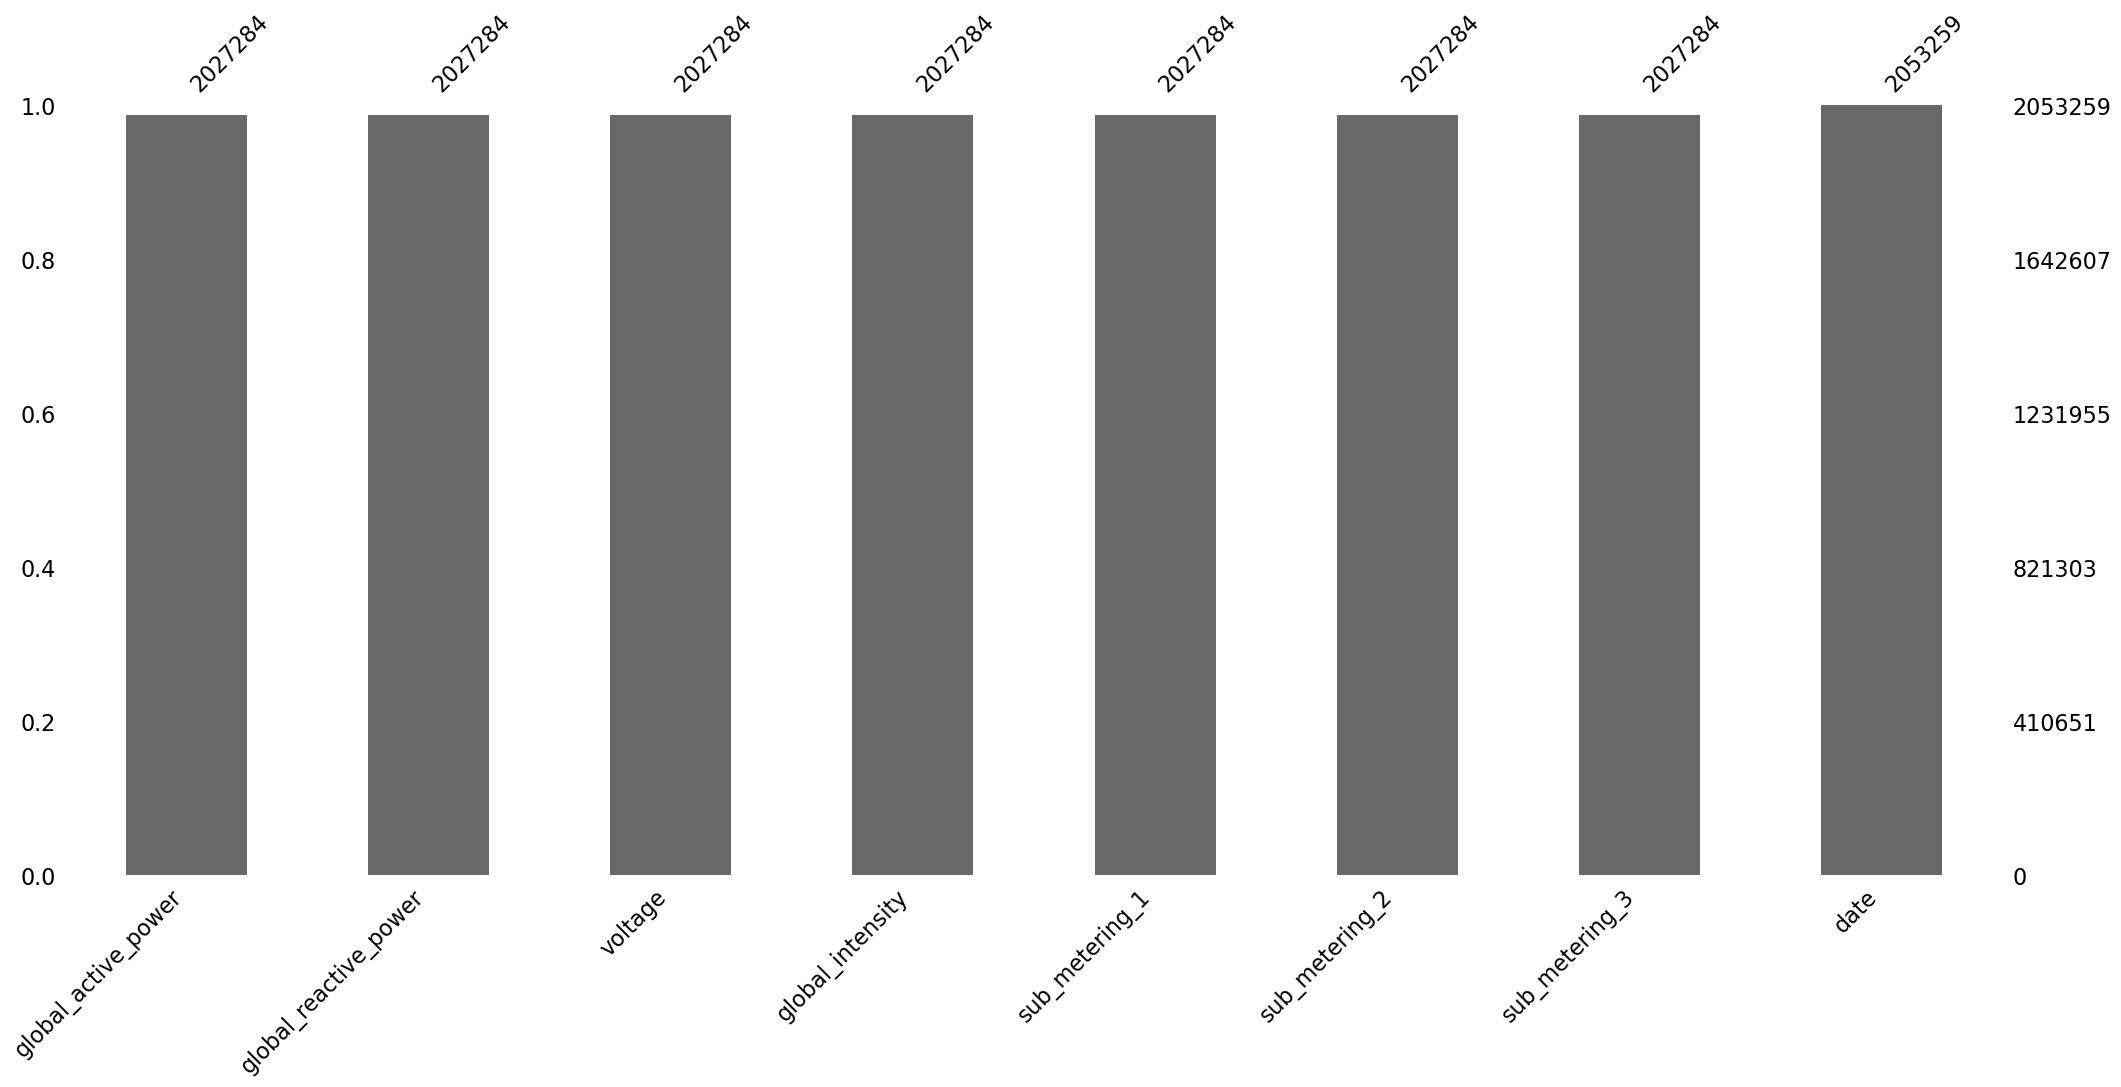

In [ ]:
#generate barplots and heatmaps to explore missing data
msno.bar(df_household)
#msno.heatmap(df_household)

<AxesSubplot:>

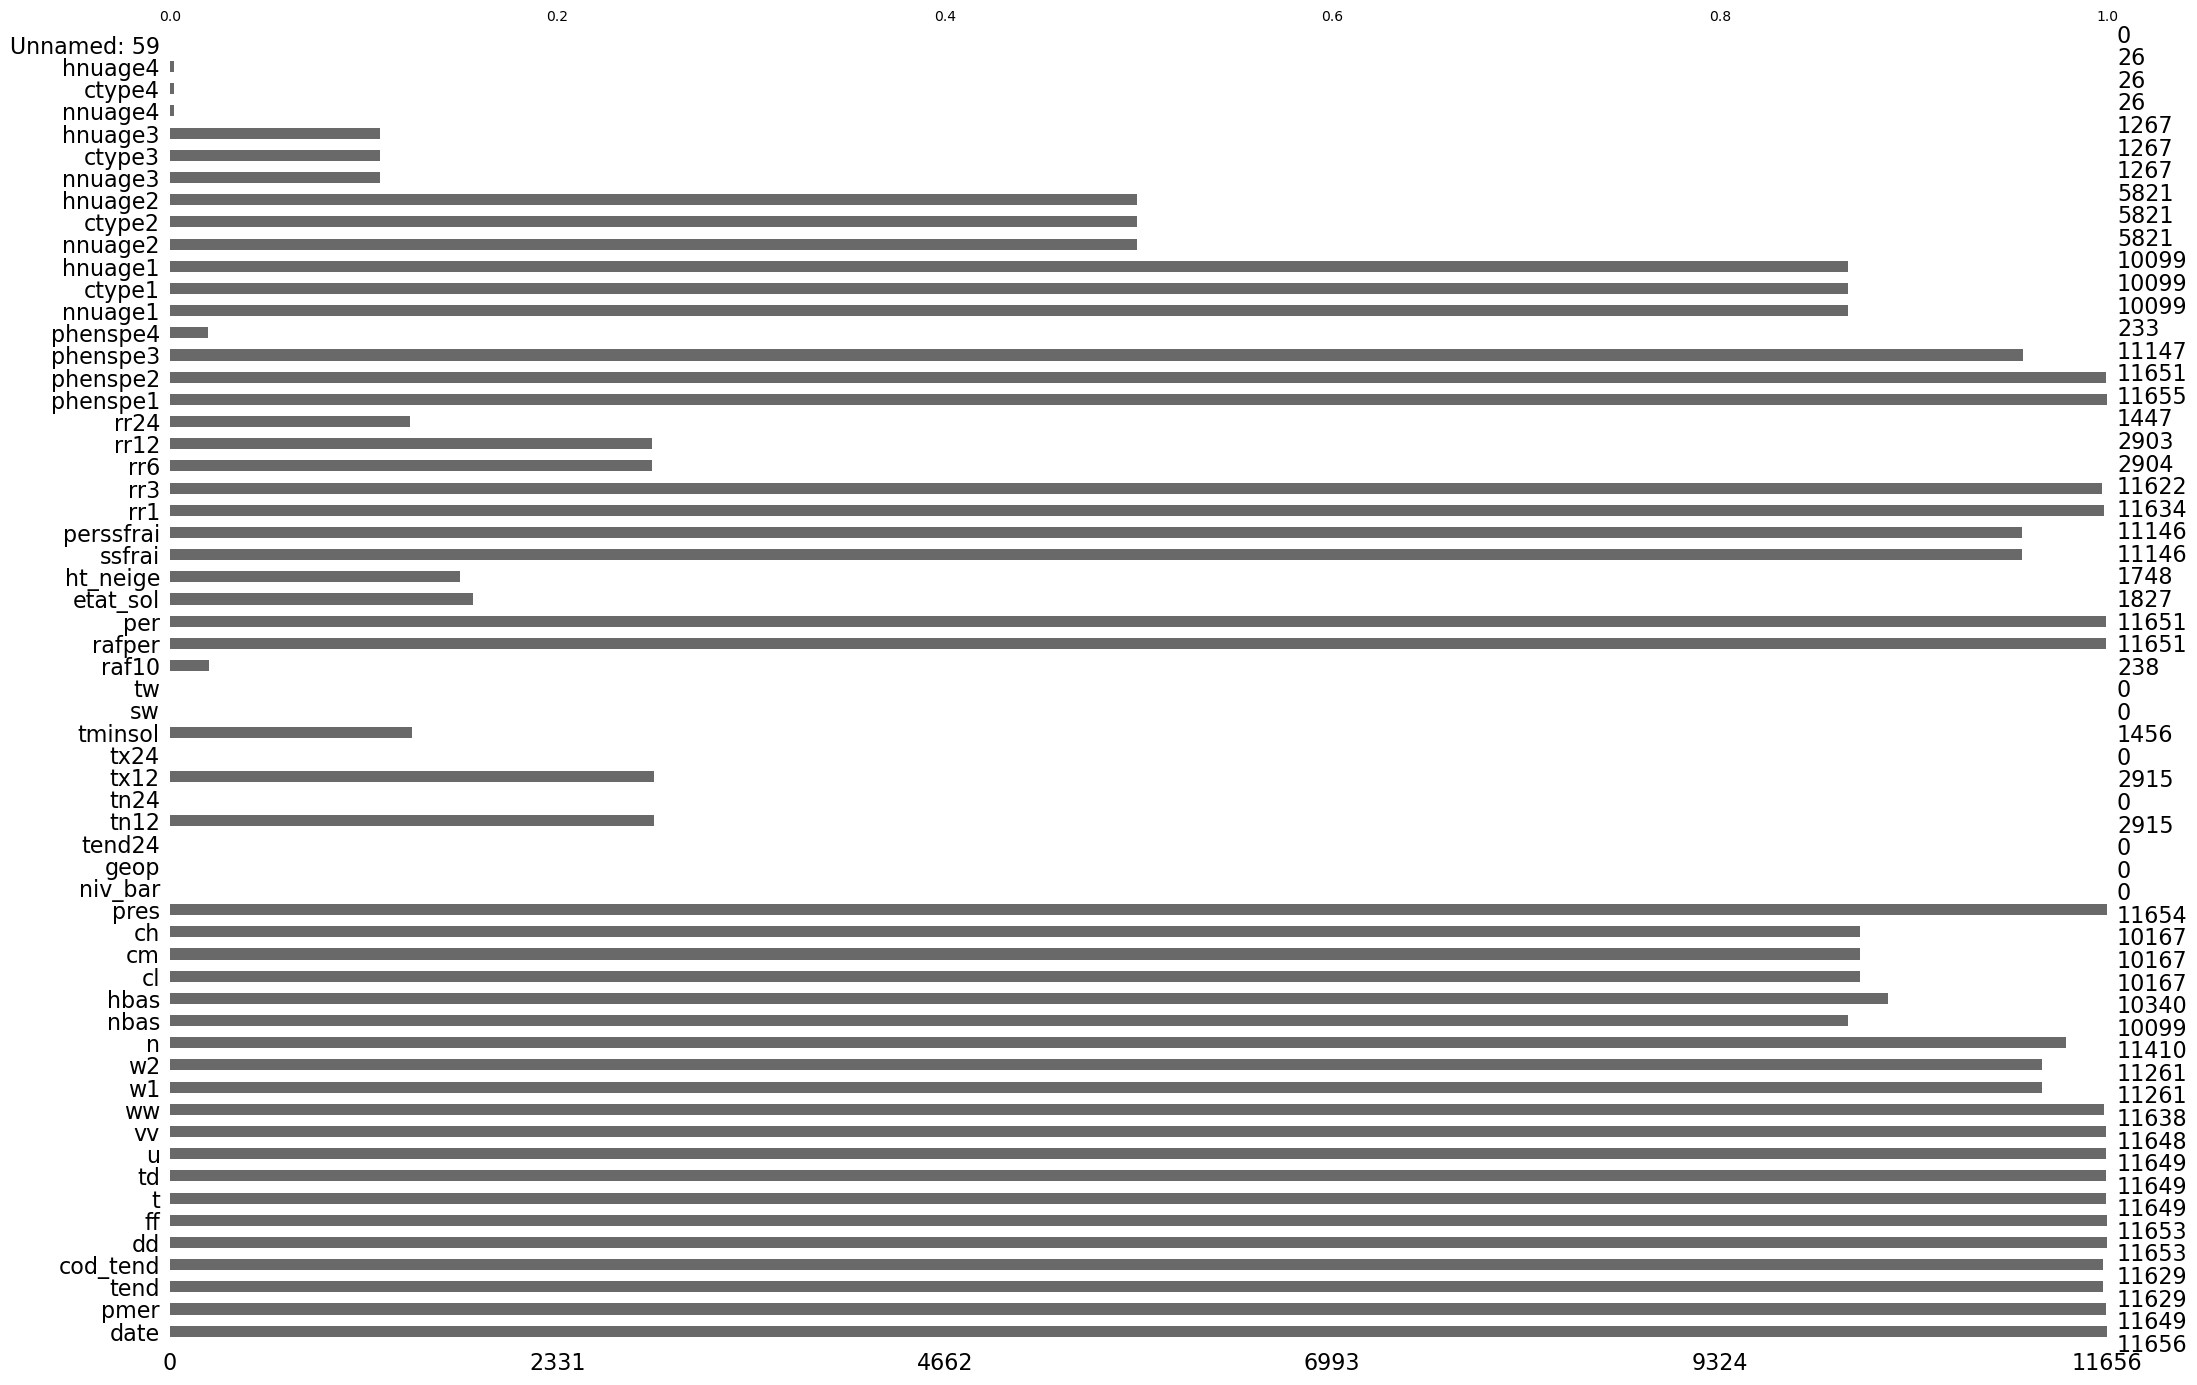

In [ ]:
msno.bar(df_station)
#msno.heatmap(df_station)

We interpolate missing data for the household dataframe.

<AxesSubplot:>

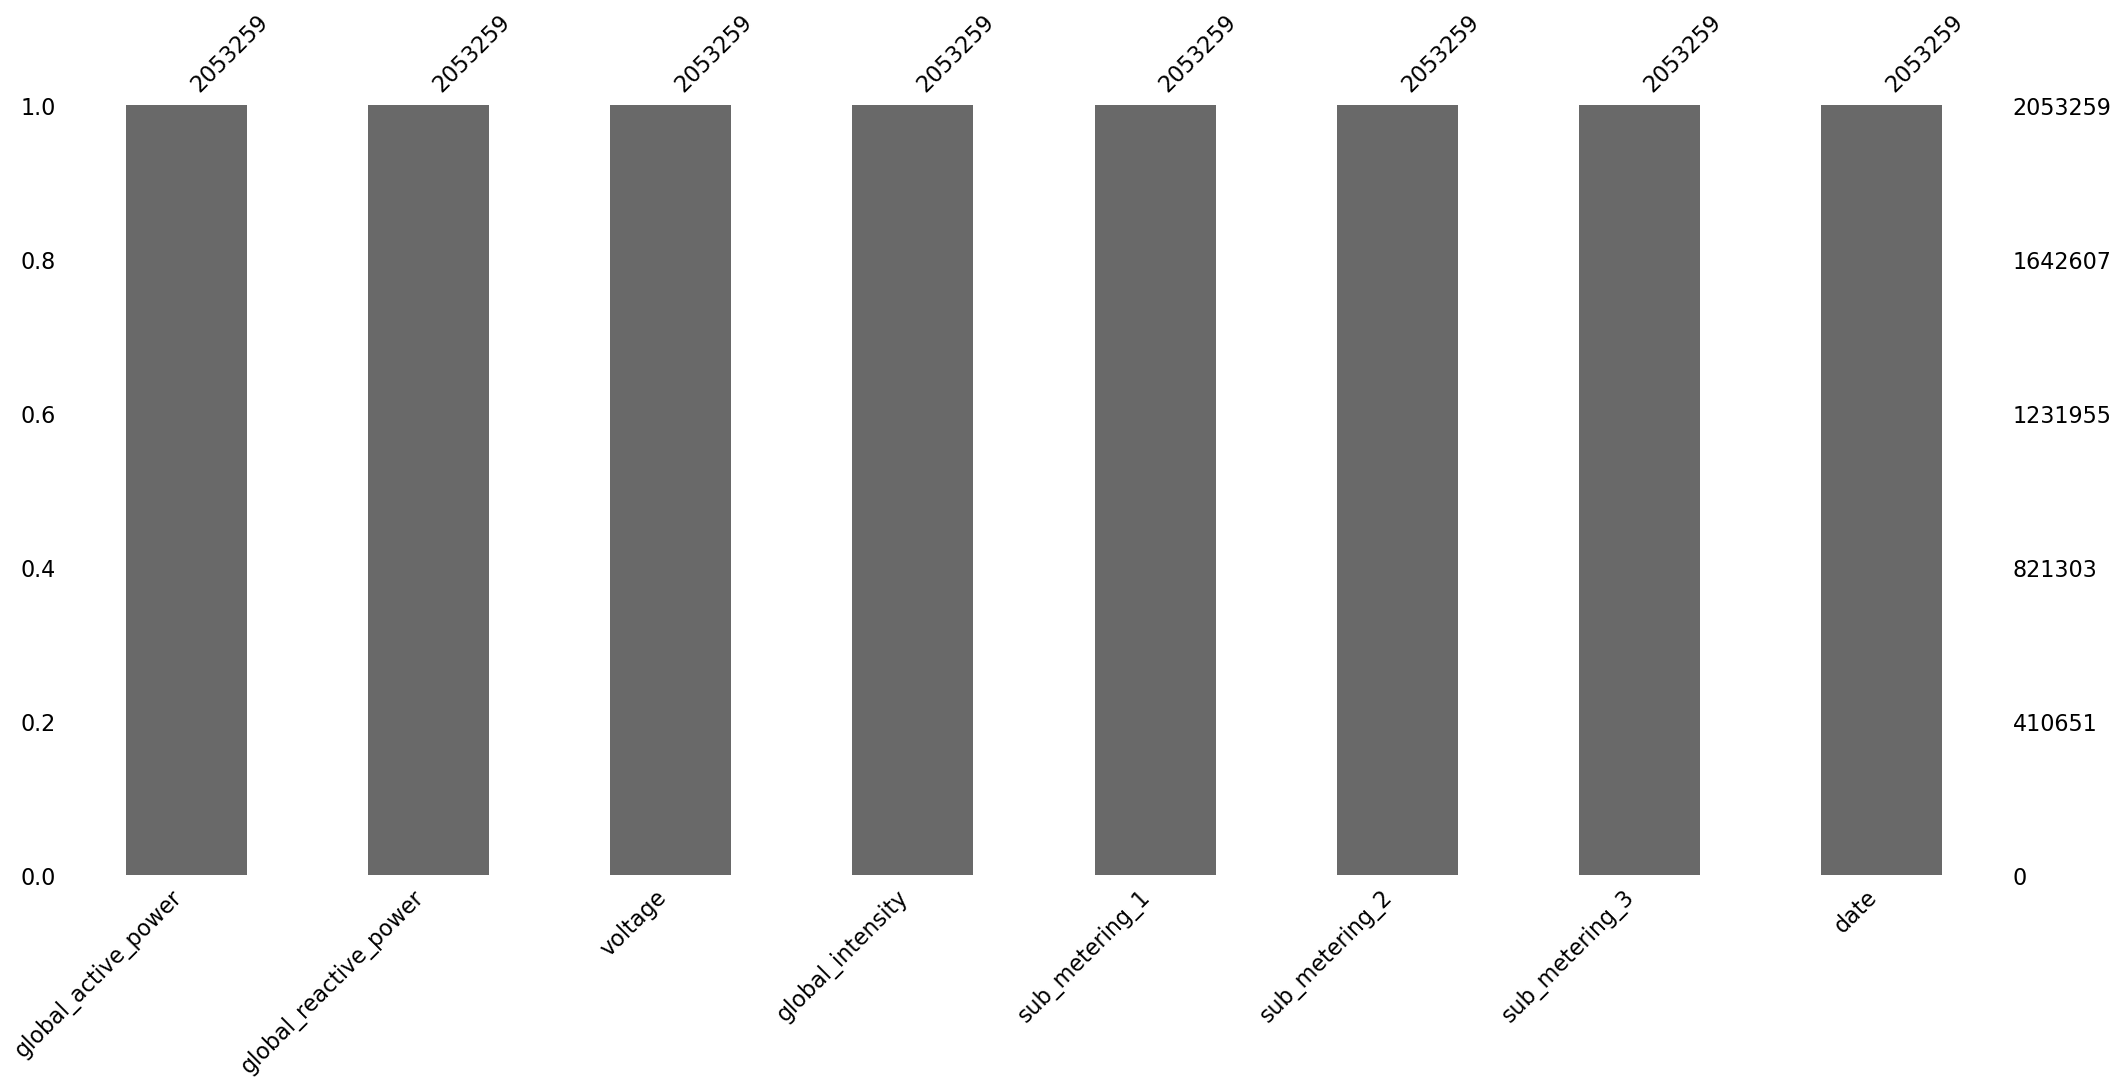

In [ ]:
df_household = df_household.interpolate()
msno.bar(df_household)

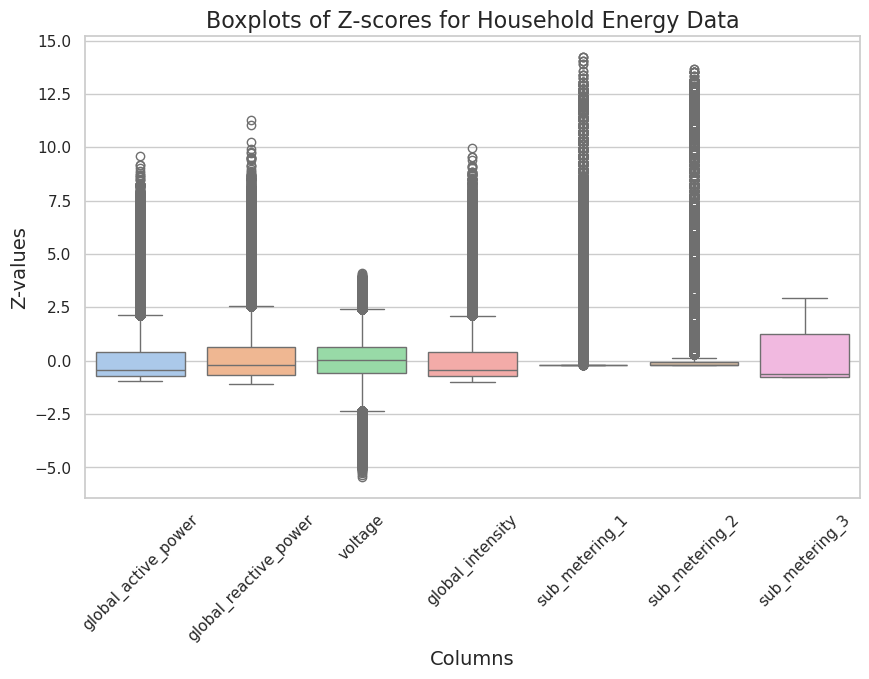

In [ ]:
# Calculate Z-scores for the columns of interest
z_scores = (df_household[['global_active_power', 'global_reactive_power', 'voltage', 'global_intensity', 'sub_metering_1', 'sub_metering_2', 'sub_metering_3']] - df_household[['global_active_power', 'global_reactive_power', 'voltage', 'global_intensity', 'sub_metering_1', 'sub_metering_2', 'sub_metering_3']].mean()) / df_household[['global_active_power', 'global_reactive_power', 'voltage', 'global_intensity', 'sub_metering_1', 'sub_metering_2', 'sub_metering_3']].std()

# Set the style and color palette
sns.set(style="whitegrid", palette="pastel")

# Create a larger figure
plt.figure(figsize=(10, 6))

# Plot boxplots for Z-scores
sns.boxplot(data=z_scores, orient="v")

# Set title and axis labels with larger font size
plt.title('Boxplots of Z-scores for Household Energy Data', fontsize=16)
plt.xlabel('Columns', fontsize=14)
plt.ylabel('Z-values', fontsize=14)

# Customize the x-axis labels and rotate them
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6], labels=['global_active_power', 'global_reactive_power', 'voltage', 'global_intensity', 'sub_metering_1', 'sub_metering_2', 'sub_metering_3'], rotation=45)

# Show plot
plt.show()